In [42]:
from __future__ import division
import re
import os
import pandas as pd
import math
import nltk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
%matplotlib inline  

In [43]:
def split_in_chunks(text, chunk_size):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i:i + chunk_size])
    if len(chunks) > 1 and len(chunks[-1]) < 10:
        chunks[-2] += chunks[-1]
        chunks.pop(-1)
    return chunks


def unique_chars_per_chunk_percentage(text, chunk_size):
    chunks = split_in_chunks(text, chunk_size)
    unique_chars_percentages = []
    for chunk in chunks:
        total = len(chunk)
        unique = len(set(chunk))
        unique_chars_percentages.append(unique / total)
    return sum(unique_chars_percentages) / len(unique_chars_percentages) * 100


def vowels_percentage(text):
    vowels = 0
    total = 0
    for c in text:
        if not c.isalpha():
            continue
        total += 1
        if c in "aeiouAEIOU":
            vowels += 1
    if total != 0:
        return vowels / total * 100
    else:
        return 0


def word_to_char_ratio(text):
    chars = len(text)
    words = len([x for x in re.split(r"[\W_]", text) if x.strip() != ""])
    return words / chars * 100


def deviation_score(percentage, lower_bound, upper_bound):
    if percentage < lower_bound:
        return math.log(lower_bound - percentage, lower_bound) * 100
    elif percentage > upper_bound:
        return math.log(percentage - upper_bound, 100 - upper_bound) * 100
    else:
        return 0


def classify(text):
    if text is None or len(text) == 0:
        return 0.0
    ucpcp = unique_chars_per_chunk_percentage(text, 35)
    vp = vowels_percentage(text)
    wtcr = word_to_char_ratio(text)

    ucpcp_dev = max(deviation_score(ucpcp, 45, 50), 1)
    vp_dev = max(deviation_score(vp, 35, 45), 1)
    wtcr_dev = max(deviation_score(wtcr, 15, 20), 1)

    return max((math.log10(ucpcp_dev) + math.log10(vp_dev) + math.log10(wtcr_dev)) / 6 * 100, 1)


def load_csv_as_df(file_name, sub_directories, col_name=None):
    '''
    Load any csv as a pandas dataframe. Provide the filename, the subdirectories, and columns to read(if desired).
    '''
    # sub_directories = '/Data/'
    base_path = os.getcwd()
    full_path = base_path + sub_directories + file_name
    
    if col_name is not None:
        return pd.read_csv(full_path, usecols=[col_name])
    
    # print('Full Path: ', full_path)
    return pd.read_csv(full_path, header=0)


def calculate_account_age_in_days(df):
    df['tweet_time'] = pd.to_datetime(df['tweet_time'])
    df['user_created_at'] = pd.to_datetime(df['user_created_at'])
    ages = []
    today = datetime.datetime.now()

    for index, row in df.iterrows():
        age = days_between_dates(row['user_created_at'], row['tweet_time'])
        ages.append(age)
        
    df['age_in_days'] = ages
    return df


def days_between_dates(date_one, date_two):
    """
    :param date_one: datetime.datetime
    :param date_two: datetime.datetime
        https://docs.python.org/3/library/datetime.html#datetime-objects
    :return: Int - number of days between those two dates
    """
    d1 = datetime.date(date_one.year, date_one.month, date_one.day)
    d2 = datetime.date(date_two.year, date_two.month, date_two.day)
    delta = d2 - d1
    
    if abs((d2 - d1).days) > 0:
        return abs(delta.days)
    else:
        # Account cannot be less than 1 day old
        return 1



def add_friends_to_followers_ratio(df):
    # df = df['user_followers_count'].astype('int64')
    # df = df['user_friends_count'].astype('int64')
    df['followers_to_following_ratio'] = df.apply(lambda x: x['user_followers_count'] if x['user_friends_count'] < 1 else x['user_followers_count'] / x['user_friends_count'], axis=1)
    return df


def add_user_description_word_and_length(df):
    description_lengths = []
    number_of_words_counts = []

    for row_index, row in df.iterrows():

        user_description = row['user_description']

        if isinstance(user_description, float):
            # Some descriptions are blank which Pandas converts to NaN
            # Here we assign any row with NaN in the description to have a length of 0
            #
            description_length = 0
            number_of_words = 1
        else:
            description_length = len(str(row['user_description']))
            words = row['user_description'].split()
            number_of_words = len(words)

        description_lengths.append(description_length)
        number_of_words_counts.append(number_of_words)

    df['user_description_length'] = description_lengths
    df['user_description_word_count'] = number_of_words_counts

    return df


def drop_useless_cols(df):
    
    """ Here we can only keep the columns that can easily be mapped to a float. For example description by itself cannot
        easily be mapped to a float. The variability amoung user descriptions would make this value useless. """
    
    df.drop('user_id', axis=1, inplace=True)
    df.drop('bot_score', axis=1, inplace=True)
    df.drop('cap', axis=1, inplace=True)
    df.drop('tweet_time', axis=1, inplace=True) # drop bot_score and CAP to see if we can determine bot status without this information
    df.drop('tweet_text', axis=1, inplace=True)
    df.drop('user_url', axis=1, inplace=True) # drop because this is assinged by Twitter
    df.drop('user_profile_image_url', axis=1, inplace=True) # drop because this is assinged by Twitter
    df.drop('user_description', axis=1, inplace=True)
    df.drop('user_location', axis=1, inplace=True)
    df.drop('user_following', axis=1, inplace=True) # boolean flag if I follow that account
    df.drop('user_created_at', axis=1, inplace=True)
    df.drop('user_name', axis=1, inplace=True)
    df.drop('user_listed_count.1', axis=1, inplace=True) # duplicate column for some reason
    df.drop('user_verified', axis=1, inplace=True) # can still be a bot
    df.drop('user_screen_name', axis=1, inplace=True)
    df.drop('user_profile_background_color', axis=1, inplace=True)
    df.drop('user_utc_offset', axis=1, inplace=True) # Null for just about every row
    df.drop('user_time_zone', axis=1, inplace=True) # Same as above
    df.drop('tweet_count', axis=1, inplace=True) # drop because this is the count for the number of tweets in that stream file
    
    return df


def map_languages_to_int(df):
    languages = df.user_lang.unique()
    language_map = dict(zip(languages, range(len(languages))))
    df['user_lang'] = df['user_lang'].map(lambda s: language_map.get(s) if s in language_map else s)
    return df


def combine_dfs(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)


def load_full_master_list():
    kav_only_df = load_csv_as_df('Kav-MasterIDs.csv', '/Data/Master-Data/')
    almost_full_df = load_csv_as_df('MasterIDs-4.csv', '/Data/Master-Data/')
    df = pd.concat([kav_only_df, almost_full_df])
    df = df.sort_values('cap')
    df = df.drop_duplicates('user_id', keep='last')
    return df


def get_profiles_before(master_df, recheck_id_list):
    return master_df[master_df['user_id'].isin(recheck_id_list)]


def load_removed_ids():
    df = load_csv_as_df('RemovedIDs.csv', '/Data/Removed-Data/')
    df2 = load_csv_as_df('RemovedIDs-2.csv', '/Data/Removed-Data/')
    
    return pd.concat([df, df2])


def load_still_active():
    df = load_csv_as_df('StillActiveIDs.csv', '/Data/Removed-Data/')
    df2 = load_csv_as_df('StillActiveIDs-2.csv', '/Data/Removed-Data/')
    
    return pd.concat([df, df2])

In [44]:
active_df = load_still_active()

In [45]:
df = load_full_master_list()
df = add_friends_to_followers_ratio(df)
df = add_user_description_word_and_length(df)
df = map_languages_to_int(df)
df = calculate_account_age_in_days(df) # adds account age at time of tweet to df
df['user_name'] = df['user_name'].astype(str)
df['user_screen_name'] = df['user_screen_name'].astype(str)

df['name_gibberish'] = df['user_name'].apply(lambda x: classify(x))
df['screen_name_gibberish'] = df['user_screen_name'].apply(lambda x: classify(x))

In [46]:
human_df = df[df.cap < 0.4]

In [47]:
recheck_df1 = load_csv_as_df('BotsToRecheck.csv', '/Data/Removed-Data/')
removed_ids_df = load_removed_ids()
before_recheck_df = get_profiles_before(df, recheck_df1.user_id.unique().tolist())
removed_df = before_recheck_df[before_recheck_df.user_id.isin(removed_ids_df.user_id.tolist())]

In [48]:
bot_df = active_df[active_df.cap >= 0.53]
bot_df = add_friends_to_followers_ratio(bot_df)
bot_df = add_user_description_word_and_length(bot_df)
bot_df = map_languages_to_int(bot_df)
bot_df = calculate_account_age_in_days(bot_df) # adds account age at time of tweet to df
bot_df['user_name'] = bot_df['user_name'].astype(str)
bot_df['user_screen_name'] = bot_df['user_screen_name'].astype(str)

bot_df['name_gibberish'] = bot_df['user_name'].apply(lambda x: classify(x))
bot_df['screen_name_gibberish'] = bot_df['user_screen_name'].apply(lambda x: classify(x))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [49]:
print(len(bot_df))
print(len(human_df))

7496
664030


In [50]:
bot_df['bot'] = True
human_df['bot'] = False
human_df = human_df.sample(len(bot_df))
full_df = combine_dfs(bot_df, human_df)
dropped_df = drop_useless_cols(full_df)
dropped_df.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_favourites_count,user_statuses_count,user_listed_count,user_followers_count,user_default_profile_image,user_friends_count,user_default_profile,user_lang,user_geo_enabled,followers_to_following_ratio,user_description_length,user_description_word_count,age_in_days,name_gibberish,screen_name_gibberish,bot
0,450,1447,0,8,False,424,True,0,False,0.018868,18,1,342,94.295323,90.895163,True
1,9,427,0,1,False,137,True,0,False,0.007299,36,2,162,32.682359,32.908218,True
2,1209,1139,0,439,False,1528,True,1,True,0.287304,3,1,1138,62.900292,63.185841,True
3,2346,10896,0,13,False,158,True,2,False,0.082278,117,10,130,86.498243,91.315252,True
4,470,16,0,9,False,28,True,1,False,0.321429,0,1,3448,80.137554,93.767798,True


In [51]:
from sklearn.cross_validation import train_test_split
df = dropped_df
y = df['bot'].tolist()
X = df.drop('bot', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

In [52]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')
lr = LogisticRegression(penalty='l1', C=0.1)
lr.fit(X_train_std, y_train)

print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.7841515474919958
Test accuracy: 0.7916221985058698


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# X = training_data[features].iloc[:,:-1]
# y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=150, min_samples_split=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.94845
Test Accuracy: 0.94153


In [54]:
from sklearn.ensemble import RandomForestClassifier

# X = training_data[features].iloc[:,:-1]
# y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=10, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

Trainig Accuracy: 0.97256
Test Accuracy: 0.95487


In [57]:
feat_labels = X.columns
forest = RandomForestClassifier(n_estimators=1000, max_depth=10,  random_state=0, n_jobs=1)
print(feat_labels)

Index(['user_favourites_count', 'user_statuses_count', 'user_listed_count',
       'user_followers_count', 'user_default_profile_image',
       'user_friends_count', 'user_default_profile', 'user_lang',
       'user_geo_enabled', 'followers_to_following_ratio',
       'user_description_length', 'user_description_word_count', 'age_in_days',
       'name_gibberish', 'screen_name_gibberish'],
      dtype='object')


In [58]:
%%time
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print ("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))

 1) user_favourites_count          0.437304
 2) user_statuses_count            0.187135
 3) user_listed_count              0.084679
 4) user_followers_count           0.074556
 5) user_default_profile_image     0.073867
 6) user_friends_count             0.040584
 7) user_default_profile           0.024145
 8) user_lang                      0.020241
 9) user_geo_enabled               0.013196
10) followers_to_following_ratio   0.013059
11) user_description_length        0.012247
12) user_description_word_count    0.007993
13) age_in_days                    0.007356
14) name_gibberish                 0.001933
15) screen_name_gibberish          0.001705
CPU times: user 12 s, sys: 187 ms, total: 12.2 s
Wall time: 12.6 s


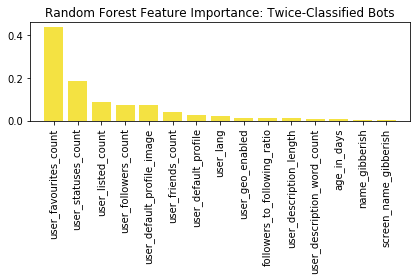

In [60]:
plt.title('Random Forest Feature Importance: Twice-Classified Bots')
plt.bar(range(X_train.shape[1]), importances[indices], color='#f4e242', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('Random Forest Feature Importance: Twice-Classified Bots.png', bbox_inches='tight')
plt.show()

In [55]:
# Perceptron
from sklearn.linear_model import Perceptron

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)
sc = StandardScaler()
sc.fit(X_train)

# Apply the scaler to the X training data
X_train_std = sc.transform(X_train)

# Apply the SAME scaler to the X test data
X_test_std = sc.transform(X_test)

# Create a perceptron object with the parameters: 40 iterations (epochs) over the data, and a learning rate of 0.1
ppn = Perceptron(n_iter=1500, eta0=0.025, random_state=0)

# Train the perceptron
ppn.fit(X_train_std, y_train)

# Apply the trained perceptron on the X data to make predicts for the y test data
y_pred = ppn.predict(X_test_std)

# View the accuracy of the model
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy: 0.739
